## Import Libraries

##  ## MECH 3465 Convolution Neural Network  Workshop

In this work workshop, we will use the Cifar-10 dataset, which consists of 60,000 32x32 color images in 10 different classes. We will learn how to use keras to build the convolutional neural network (CNN) model using the Keras library. Finally we will use MTARST  dataset [https://www.kaggle.com/datasets/aqibriaz/mtarsidataset/data] to train another CNN model using pytorch.
Install cuda from link here https://developer.download.nvidia.com/compute/cuda/12.6.3/local_installers/cuda_12.6.3_561.17_windows.exe
or use the command : [ pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu111 ]

## Task 1

In [4]:
#import libraries you used 
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

## Prepare the device and load the model

In [6]:
## check devices

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Load Data Set
*   Load the Cifar-10 dataset
*   Split into training and testing segments
  * The training segment is used for training the model, while the testing portion of the data is used to evaluate the accuracy of the model.

The dataset is extracted to the directory data/cifar10.  you need create local dirctory data folder. It contains 2 folders train and test, containing the training set (50000 images) and test set (10000 images) respectively. Each of them contains 10 folders, one for each class of images. Let's verify this using os.listdir.

In [8]:
data_dir = './cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## check the number of training and test examples for each class

In [10]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print('No. of training examples for test image:', len(airplane_files))
print(airplane_files[:5])

No. of training examples for test image: 5000
['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


In [12]:
ship_test_files = os.listdir(data_dir + "/test/ship")
print("No. of test examples for ship:", len(ship_test_files))
print(ship_test_files[:5])

No. of test examples for ship: 1000
['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


## Load Dataset
We can use the ImageFolder class from torchvision to load the data as PyTorch tensors.

In [14]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [16]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

chek the input data shape and labels.  Each element is a tuple, containing a image tensor and a label. Since the data consists of 32x32 px color images with 3 channels (RGB), each image tensor has the shape (3, 32, 32).

In [18]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.

In [20]:
#check the labels
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Preprocess the dataset and augment
Preprocess the dataset by normalizing the pixel values between 0 and 1. 


In [22]:
random_seed = 42
torch.manual_seed(random_seed);

In [24]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

We can now create data loaders for training and validation, to load the data in batches

In [26]:
from torch.utils.data.dataloader import DataLoader

batch_size=128
epochs = 10

In [28]:
# test_loader is the portion within in test dataset
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

## Creating the model

In [30]:
# Define a simple CNN model
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

In [32]:
# Define evaluation function
def evaluate(model, data_loader):
    model.eval()
    total, correct, total_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total, total_loss / len(data_loader)


In [34]:
# Initialize the model, loss function, and optimizer
model = CNNNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## train the model and keep track of the loss and accuracy over epochs

In [36]:
def train_model(model, train_loader, test_loader, epochs):
    history = {
        'train_loss': [],
        'test_loss': [],
        'train_acc': [],
        'test_acc': []
    }
    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accuracy calculation
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = correct / total
        test_acc, test_loss = evaluate(model, test_loader)

        history['train_loss'].append(train_loss / len(train_loader))
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

        print(f"Epoch [{epoch + 1}/{epochs}], "
              f"Train Loss: {train_loss / len(train_loader):.4f}, "
              f"Test Loss: {test_loss:.4f}, "
              f"Train Acc: {train_acc:.4f}, "
              f"Test Acc: {test_acc:.4f}")
    return history
 



In [38]:
from torchsummary import summary
# Summarize the model
print(summary(model, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
           Flatten-7                 [-1, 4096]               0
            Linear-8                  [-1, 256]       1,048,832
              ReLU-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
Total params: 1,070,794
Trainable params: 1,070,794
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.88
Params size (MB): 4.08
Estimat

In [40]:
# Train the model
history = train_model(model, train_loader, test_loader, epochs=10)

Epoch [1/10], Train Loss: 1.5899, Test Loss: 1.3715, Train Acc: 0.4245, Test Acc: 0.5144
Epoch [2/10], Train Loss: 1.2028, Test Loss: 1.1133, Train Acc: 0.5726, Test Acc: 0.5972
Epoch [3/10], Train Loss: 1.0409, Test Loss: 1.0198, Train Acc: 0.6331, Test Acc: 0.6436
Epoch [4/10], Train Loss: 0.9375, Test Loss: 0.9771, Train Acc: 0.6696, Test Acc: 0.6568
Epoch [5/10], Train Loss: 0.8540, Test Loss: 0.9310, Train Acc: 0.6994, Test Acc: 0.6730
Epoch [6/10], Train Loss: 0.7764, Test Loss: 0.9201, Train Acc: 0.7283, Test Acc: 0.6830
Epoch [7/10], Train Loss: 0.7091, Test Loss: 0.9247, Train Acc: 0.7513, Test Acc: 0.6756
Epoch [8/10], Train Loss: 0.6442, Test Loss: 0.9157, Train Acc: 0.7743, Test Acc: 0.6942
Epoch [9/10], Train Loss: 0.5834, Test Loss: 0.8920, Train Acc: 0.7965, Test Acc: 0.7028
Epoch [10/10], Train Loss: 0.5222, Test Loss: 0.9225, Train Acc: 0.8191, Test Acc: 0.6958


## visualize the training and test accuracy and loss

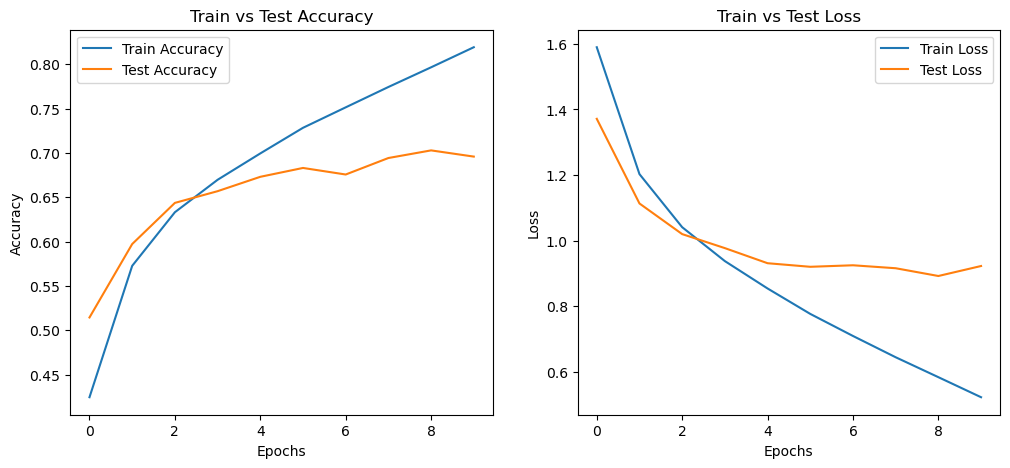

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plot the training and test accuracy and loss
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['test_acc'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()

plt.show()

## Task 2
In this task you wil train the MSTR dataset using pytorch and train a Convolutional Neural Network (CNN) to classify the MSTR dataset using weighted F1 score. You should train the model using a GPU if available.

In [44]:
import os
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader

# Paths 
dataset_path = './MSTRtest'  # Path to the dataset file
labels_path = './MSTRtest'  # Path to the labels file

In [46]:
# Preprocess data
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize([0.5], [0.5])  # Normalize
])

# Load dataset
dataset = datasets.ImageFolder(dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [56]:
# Custom CNN Model
class MSTRCNN(nn.Module):
    def __init__(self, num_classes):
        super(MSTRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # Adjust based on input size
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [58]:
# Initialize model
num_classes = len(dataset.classes)
model = MSTRCNN(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(dataloader)}")

# Evaluation loop
model.eval()
true_labels = []
predicted_labels = []
with torch.no_grad():
    for inputs, labels in dataloader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())



Epoch 1/5, Loss: 2.8496923168500263
Epoch 2/5, Loss: 1.8618170022964478
Epoch 3/5, Loss: 0.9457892189423244
Epoch 4/5, Loss: 0.43422061055898664
Epoch 5/5, Loss: 0.20585507495949665


In [66]:
# Compute F1-score
average_f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f"Average F1-Score: {average_f1}")

Average F1-Score: 0.9647340071639215
